<a href="https://colab.research.google.com/github/biepoonpoon/nbamvpprediction/blob/main/mvpprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/biepoonpoon/nbamvpprediction.git

fatal: destination path 'nbamvpprediction' already exists and is not an empty directory.


In [2]:
from nbamvpprediction.NBAStatData import NBAStatData
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


In [3]:
#ใช้ข้อมูลตังแต่ ss 1979-1980 ถึง 2019-2020

year_start = 1980
year_stop = 2020

nba = NBAStatData(year_start,year_stop,False)

In [4]:
award_share = nba.mvp_votingshare()

In [5]:
all_player_stat = pd.concat(award_share, ignore_index=True)
all_player_stat.head()

,Player,WIN%,G/TOT,MP/G,PTS,AST,TRB,STL,BLK,PF,FGA,3PA,FTA,FG%,3P%,FT%,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,PER,BPM,TS%,USG%,WS,WS/48,YEAR,Voting_Share
0,Kareem Abdul-Jabbar,0.731707,1.000000,38.329268,2034,371,886,81,280,216,1383,1,476,0.604,0.000,0.765,7.2,22.2,15.4,16.5,1.2,4.6,15.7,25.3,7.2,0.639,24.1,14.8,0.227,1980,0.665
1,Tom Abernethy,0.292683,0.817073,18.238806,362,87,191,35,12,118,318,1,82,0.481,0.000,0.683,5.4,12.0,8.6,9.3,1.4,0.6,9.9,11.0,-1.2,0.511,13.3,2.0,0.080,1980,0.000
2,Alvan Adams,0.670732,0.914634,28.906667,1118,322,609,108,55,237,875,2,236,0.531,0.000,0.797,8.2,22.4,15.4,21.6,2.3,1.4,18.2,19.2,3.6,0.571,21.9,7.0,0.155,1980,0.000
3,Tiny Archibald,0.743902,0.975610,35.800000,1131,671,197,106,10,218,794,18,435,0.482,0.222,0.830,2.3,5.3,3.8,30.2,1.7,0.2,19.7,15.3,1.1,0.574,17.0,8.9,0.148,1980,0.009
4,Dennis Awtrey,0.365854,0.317073,21.538462,86,40,115,12,15,66,60,0,50,0.450,0.000,0.640,6.0,16.9,11.5,9.0,1.0,1.5,24.8,7.4,-1.4,0.524,7.9,0.6,0.053,1980,0.000


In [6]:
mvp_candidate = all_player_stat.loc[all_player_stat["Voting_Share"] > 0]
mvp_candidate

,Player,WIN%,G/TOT,MP/G,PTS,AST,TRB,STL,BLK,PF,FGA,3PA,FTA,FG%,3P%,FT%,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,PER,BPM,TS%,USG%,WS,WS/48,YEAR,Voting_Share
0,Kareem Abdul-Jabbar,0.731707,1.000000,38.329268,2034,371,886,81,280,216,1383,1,476,0.604,0.000,0.765,7.2,22.2,15.4,16.5,1.2,4.6,15.7,25.3,7.2,0.639,24.1,14.8,0.227,1980,0.665
3,Tiny Archibald,0.743902,0.975610,35.800000,1131,671,197,106,10,218,794,18,435,0.482,0.222,0.830,2.3,5.3,3.8,30.2,1.7,0.2,19.7,15.3,1.1,0.574,17.0,8.9,0.148,1980,0.009
17,Larry Bird,0.743902,1.000000,36.036585,1745,370,852,143,53,279,1463,143,360,0.474,0.406,0.836,8.3,23.6,16.0,18.5,2.3,1.0,14.0,20.5,4.5,0.538,25.3,11.2,0.182,1980,0.068
84,Julius Erving,0.719512,0.951220,36.051282,2100,355,576,170,140,208,1614,20,534,0.519,0.200,0.787,8.6,12.9,10.9,21.4,2.8,2.7,13.3,25.4,7.6,0.568,30.3,12.5,0.213,1980,0.143
97,George Gervin,0.500000,0.951220,37.615385,2585,202,403,110,79,208,1940,102,593,0.528,0.314,0.852,5.7,8.9,7.3,11.0,1.6,1.4,10.3,24.0,3.9,0.587,31.7,10.6,0.173,1980,0.086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16887,Kawhi Leonard,0.680556,0.791667,32.421053,1543,280,402,103,33,113,1133,325,402,0.470,0.378,0.886,3.1,19.1,11.3,26.4,2.6,1.6,10.2,26.9,8.9,0.589,33.0,8.7,0.226,2020,0.166
16890,Damian Lillard,0.472973,0.891892,37.484848,1978,530,284,70,22,114,1349,674,518,0.463,0.401,0.888,1.4,10.5,6.0,34.4,1.3,0.8,11.0,26.9,7.5,0.627,30.3,11.6,0.225,2020,0.023
16989,Chris Paul,0.611111,0.972222,31.542857,1232,472,349,111,11,158,887,304,279,0.489,0.365,0.907,1.3,15.7,8.7,34.0,2.4,0.4,13.8,21.7,4.4,0.610,23.3,8.9,0.193,2020,0.026
17042,Pascal Siakam,0.736111,0.833333,35.166667,1371,207,439,61,53,170,1104,365,303,0.453,0.359,0.792,3.3,18.3,11.0,16.4,1.4,2.5,10.7,17.9,1.8,0.554,28.1,5.4,0.123,2020,0.017


## กำหนดปัญหา

การที่จะทำนายผลผู้เล่นที่มีโอกาศจะได้ชนะรางวัล MVP นั้น จำเป็นต้องใช้คอลัมน์  Voting_Share เป็น target ในการวิเคราะห์ จึงได้เลือกใช้ regression model มาแก้ปัญหานี้ โดยแต่ละ column ของข้อมูลจะมีผลต่อคะแนนของ target ของเรา

โดย Voting_Share นั้นจะมีค่าอยู่ที่ 0-1 แสดงถึงคะแนนที่โหวตให้กับผู้เล่นแต่ละคน แต่จาก histrogram ด้านล่างจะเห็นว่า ข้อมูลนั้นไปกองกันที่ 0.0-0.2 ซึ่งแาจเป็นปัญหาในการสร้างโมเดล




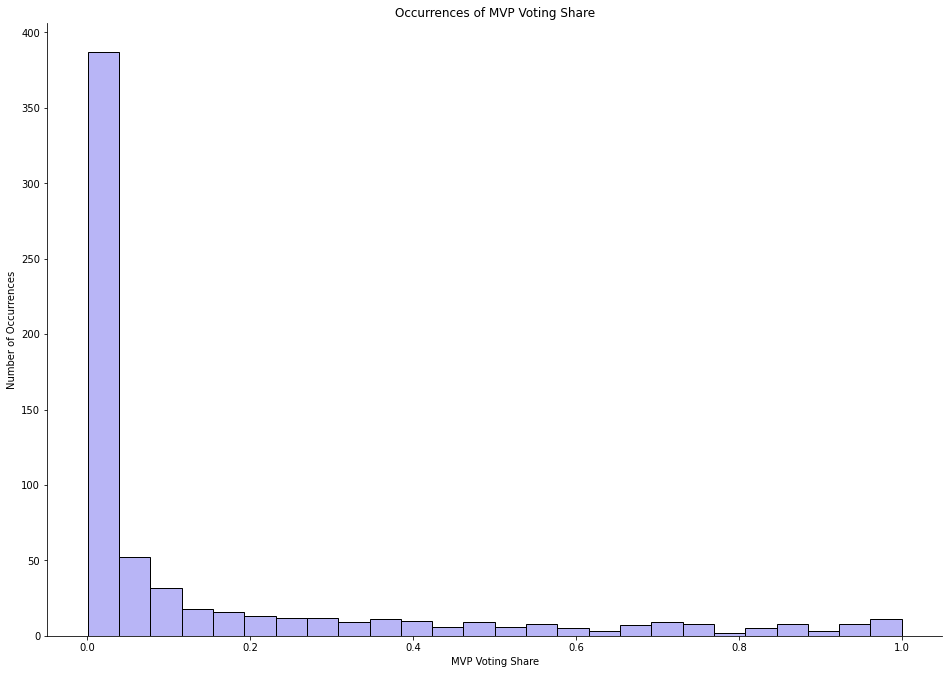

In [7]:
hist = sns.displot(data = mvp_candidate["Voting_Share"], color="#A09CF3")
hist.set(xlabel = "MVP Voting Share", ylabel= "Number of Occurrences")
plt.title('Occurrences of MVP Voting Share')
hist.fig.set_figwidth(15)
hist.fig.set_figheight(10)

# Feature Selection






## Correlation matrix


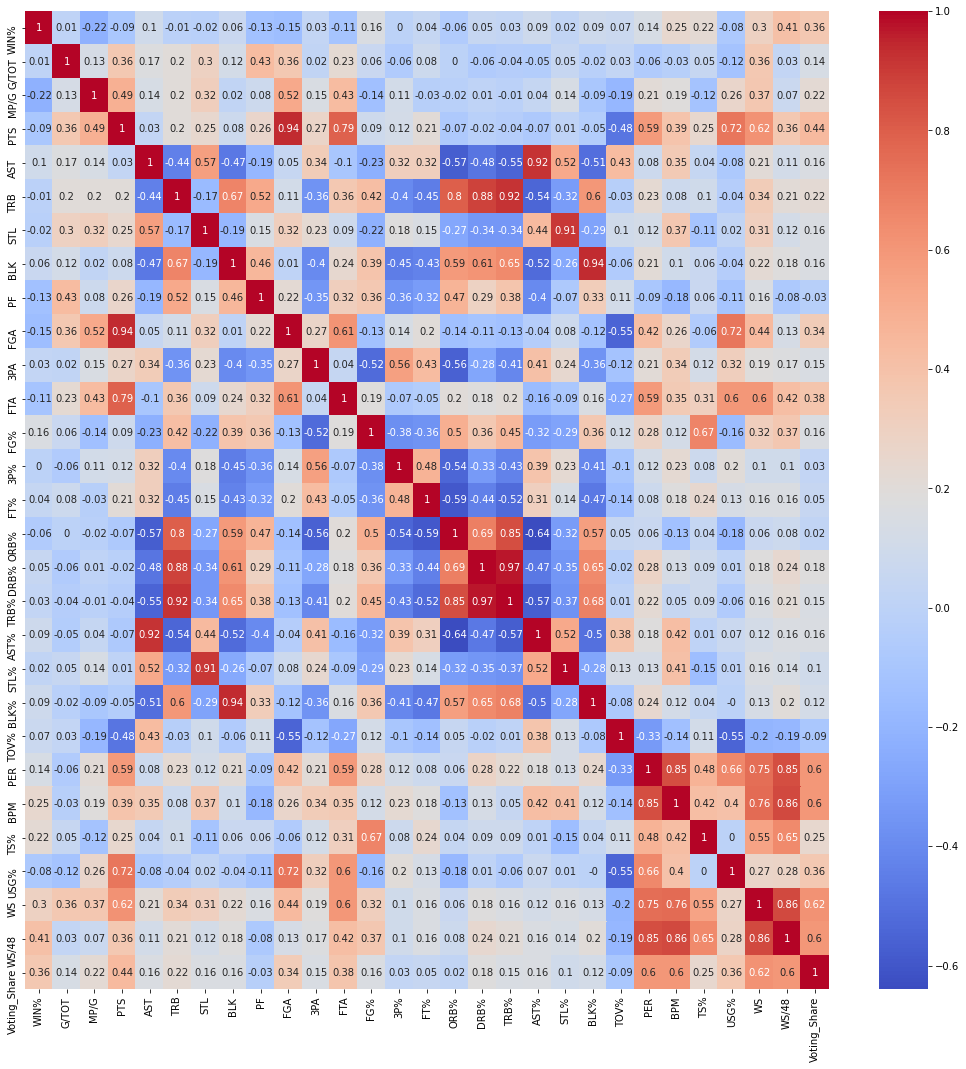

In [8]:
feature  = mvp_candidate.drop(columns=["YEAR"])


fig = plt.figure(figsize=(18, 18))
fig.set_facecolor('white')

cor = feature.corr()

sns.heatmap(round(cor,2), annot=True, cmap="coolwarm")

In [69]:
#Correlation with output variable
cor_target = abs(cor["Voting_Share"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

PER             0.595984
BPM             0.600281
WS              0.622540
WS/48           0.597832
Voting_Share    1.000000
Name: Voting_Share, dtype: float64

PER และ BPM มีสัมพันธ์กันเองสูงมากจึงต้องเลือกมา 1 ตัวเพื่อใช้ในการสร้างโมเดล
เช่นเดียวกับ WS และ WS/48 ที่เป็นสถิติเดียวกัน

ส่วนสถิติที่เป็น % ตัดทิ้ง เพราะมีการใช้ total stat อยู่แล้ว

FGA และ FTA สมีความสัมพันธ์กับ USG% จึงนำ USG%  มาวิเคราะห์

In [10]:
selected_feature = ["WIN%", "PTS", "AST", "TRB", "STL", "BLK", "BPM", "TS%", "USG%", "WS", "MP/G", ]

In [11]:
train_df = mvp_candidate.loc[(mvp_candidate["YEAR"] < 2020)]
train_df = train_df[selected_feature+["YEAR","Voting_Share"]]
train_df

,WIN%,PTS,AST,TRB,STL,BLK,BPM,TS%,USG%,WS,MP/G,YEAR,Voting_Share
0,0.731707,2034,371,886,81,280,7.2,0.639,24.1,14.8,38.329268,1980,0.665
3,0.743902,1131,671,197,106,10,1.1,0.574,17.0,8.9,35.800000,1980,0.009
17,0.743902,1745,370,852,143,53,4.5,0.538,25.3,11.2,36.036585,1980,0.068
84,0.719512,2100,355,576,170,140,7.6,0.568,30.3,12.5,36.051282,1980,0.143
97,0.500000,2585,202,403,110,79,3.9,0.587,31.7,10.6,37.615385,1980,0.086
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16321,0.451220,1505,454,465,72,33,8.0,0.588,31.6,7.2,35.218182,2019,0.001
16332,0.658537,1604,580,865,108,55,9.1,0.589,27.4,11.8,31.300000,2019,0.210
16364,0.707317,1596,199,439,106,24,7.2,0.606,30.3,9.5,34.000000,2019,0.013
16368,0.646341,2067,551,371,88,34,6.4,0.588,29.3,12.1,35.475000,2019,0.068


In [12]:
test_df = mvp_candidate.loc[(mvp_candidate["YEAR"] == 2020)]
test_df = test_df[selected_feature+["Voting_Share"]]
test_df

,WIN%,PTS,AST,TRB,STL,BLK,BPM,TS%,USG%,WS,MP/G,Voting_Share
16606,0.767123,1857,354,856,61,66,11.5,0.613,37.5,11.1,30.428571,0.952
16675,0.602740,1157,350,386,103,32,5.4,0.585,25.1,9.0,33.775862,0.009
16716,0.732394,1618,200,577,91,143,8.0,0.610,29.3,11.1,34.370968,0.081
16727,0.573333,1759,538,573,62,14,8.4,0.585,36.8,8.8,33.557377,0.198
16791,0.611111,2335,512,446,125,60,9.6,0.626,36.3,13.1,36.514706,0.363
16843,0.732394,1698,684,525,78,36,8.4,0.577,31.5,9.8,34.567164,0.746
16854,0.630137,1456,512,711,85,44,7.4,0.605,26.6,9.8,32.000000,0.018
16887,0.680556,1543,280,402,103,33,8.9,0.589,33.0,8.7,32.421053,0.166
16890,0.472973,1978,530,284,70,22,7.5,0.627,30.3,11.6,37.484848,0.023
16989,0.611111,1232,472,349,111,11,4.4,0.610,23.3,8.9,31.542857,0.026


#Train and Test data

In [16]:
X_train = train_df.drop(columns = ["YEAR","Voting_Share"])
y_train = train_df["Voting_Share"]

X_test = test_df.drop(columns = ["Voting_Share"])
y_test = test_df["Voting_Share"]


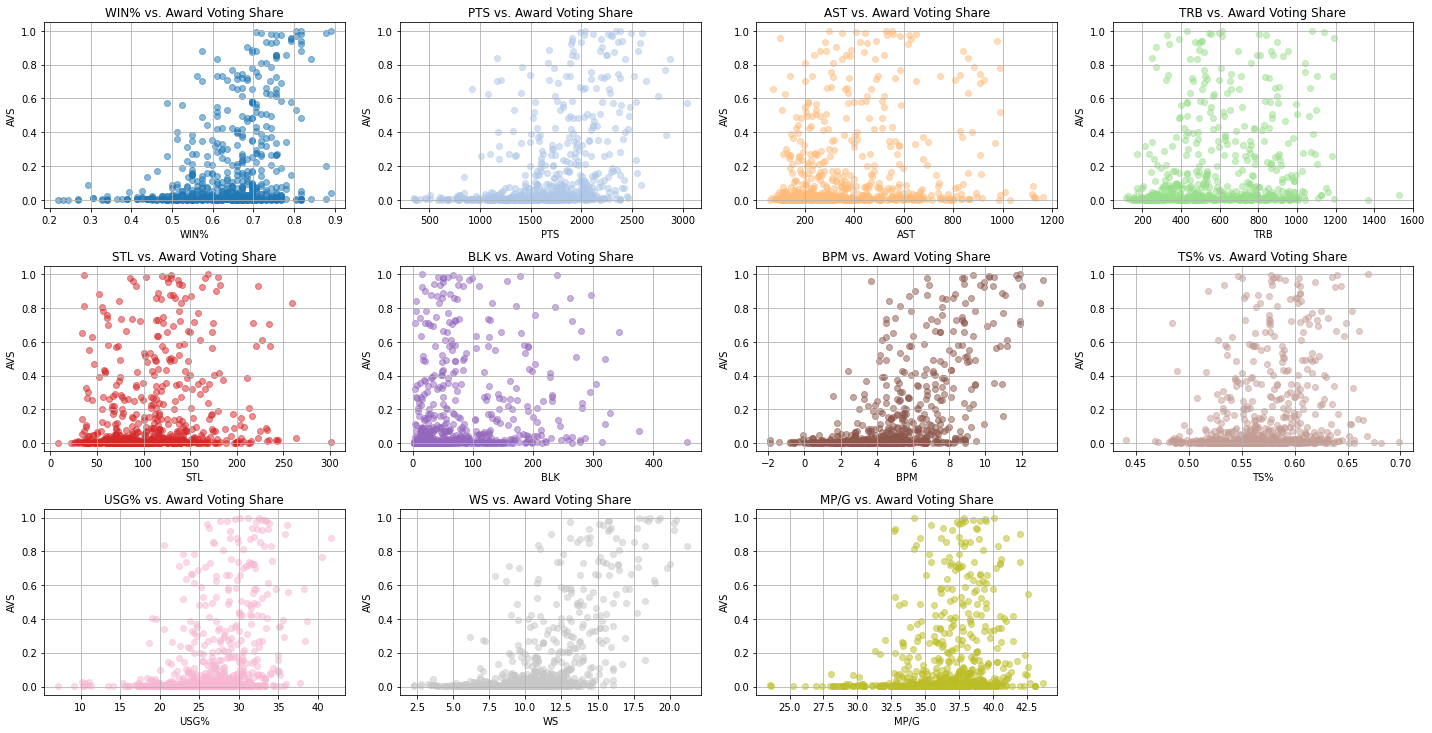

In [14]:
color=iter(plt.cm.tab20(np.linspace(0, 1, len(train_df.columns))))    

plt.figure(figsize=(20, 20))
for ifeature, feature in enumerate(X_train.columns):

    plt.subplot(6, 4, ifeature+1)

    plt.title("{} vs. Award Voting Share".format(feature))
    plt.xlabel(feature)
    plt.ylabel('AVS')
    plt.scatter(X_train[feature], y_train, color=next(color), alpha=0.5)
    plt.grid(True)
    plt.tight_layout()

# Regression

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Multiple Linear Regression

In [17]:
mlr = LinearRegression()
mlr = mlr.fit(X_train, y_train)

In [25]:
mlr.score(X_train, y_train) #R^2

0.5152860157482488

In [33]:
y_true = y_test.to_list()
y_pred = mlr.predict(X_test)

print(f"MSE : {mean_squared_error(y_true, y_pred)}")

MSE : 0.03585129797506746


### ตารางการทำนายผล

In [46]:
#test with MVP candidate SS 2019-2020

player = mvp_candidate.loc[(mvp_candidate["YEAR"] == 2020)]
prediction = pd.DataFrame({"Player":player["Player"], "True_AVS": y_true, "Predict_AVS": y_pred})
prediction.sort_values(by=['True_AVS'], ascending=False).reset_index(drop=True)
prediction.index = np.arange(1, len(prediction) + 1)

prediction

,Player,True_AVS,Predict_AVS
1,Giannis Antetokounmpo,0.952,0.532359
2,Jimmy Butler,0.009,0.037712
3,Anthony Davis,0.081,0.282103
4,Luka Dončić,0.198,0.290764
5,James Harden,0.363,0.381301
6,LeBron James,0.746,0.375310
7,Nikola Jokić,0.018,0.209604
8,Kawhi Leonard,0.166,0.240268
9,Damian Lillard,0.023,0.163319
10,Chris Paul,0.026,-0.010500


In [65]:
#test with all player in Season 2019-2020 show top10 Score
player2020 = all_player_stat.loc[all_player_stat["YEAR"] == 2020]

predict_player2020 = mlr.predict(player2020[selected_feature])
predict_avs_score = pd.DataFrame({"Player":player2020["Player"], "Predict_AVS": predict_player2020})
predict_avs_score = predict_avs_score.sort_values(by=['Predict_AVS'], ascending=False).reset_index(drop=True)

predict_avs_score.index = np.arange(1, len(predict_avs_score) + 1)
predict_avs_score.head(10)

,Player,Predict_AVS
1,Giannis Antetokounmpo,0.532359
2,James Harden,0.381301
3,LeBron James,0.375310
4,Luka Dončić,0.290764
5,Anthony Davis,0.282103
6,Kawhi Leonard,0.240268
7,Nikola Jokić,0.209604
8,Damian Lillard,0.163319
9,Khris Middleton,0.081853
10,Jayson Tatum,0.057598
